# Data
### 1. Acquisition

(Source: [LA Sheriff](http://shq.lasdnews.net/CrimeStats/CAASS/desc.html))
Archive files come by year ( 50MB to 65MB about Xe5 records per file )
with ~30 categories and short verbal description of semi-structured dictionary.

Location is X,Y geocode State Plane 5 format.
Depend on crime category location and time might be missing.
Location might be recovered via ZIPcode and vise verse for some records.
(ATTENTION: in April 2018 the files have been regenerated without coordinates
which makes this data much less interesting, as geocoding does not produce satisfying results: do not reload the archive if you have the older version.)

The current data comes as a daily updated 30 days window in the same format.

#### Download:
<pre>
START_YEAR=2005
CURRENT_YEAR=$(date +'%Y')
DIR=$(cd "$( dirname "${BASH_SOURCE[0]}" )" && pwd)

if [ -d $DIR/archive ]; then
    echo "Local archive exists"
else
    mkdir $DIR/archive
fi

if ! [ -d $DIR/data ]; then
    mkdir $DIR/data
fi

let Y=$START_YEAR
while [[ $Y -lt $CURRENT_YEAR ]]
do
    if [ -f $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv.gz ]; then
        echo "$Y using local archive..."
        gzip -d $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv.gz
    else
        curl -o $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv \
                http://shq.lasdnews.net/CrimeStats/CAASS/$Y-PART_I_AND_II_CRIMES.csv
    fi

    tr '[:upper:]' '[:lower:]' < $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv > $DIR/data/$Y.csv
    perl -pi -e 's/[[:^ascii:]]//g' $DIR/data/$Y.csv
    sed -i '1!b;s/"//g' $DIR/data/$Y.csv
    gzip $DIR/archive/$Y-PART_I_AND_II_CRIMES.csv
    ((Y = Y + 1))
done
</pre>

### 2. Audit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data/2010.csv')
df.head()

,incident_date,incident_reported_date,category,stat,stat_desc,address,street,city,zip,x_coordinate,y_coordinate,incident_id,reporting_district,seq,gang_related,unit_id,unit_name,deleted
0,1/1/2010 3:48:00 am,1/1/2010,vehicle / boating laws,255,vehicle and boating laws: misdemeanor,"albertoni st & broadway, carson, ca",albertoni st & broadway,carson,NaN,6.477110e+06,1.775513e+06,910-00007-1610,1610,7,no,ca0190016,carson,n
1,1/1/2010 3:35:00 am,1/1/2010,drunk driving vehicle / boat,242,drunk driving - vehicle/boat: alc/drugs,"2718 evelyn ave, rosemead, ca 91770",2718 evelyn ave,rosemead,91770.0,6.531129e+06,1.844414e+06,910-00007-0532,532,7,no,ca0190005,temple,n
2,1/1/2010 4:13:00 am,1/1/2010,larceny theft,389,"theft, petty: other (from prvt res, boat, plan...","888 e dominguez st, carson, ca 90745",888 e dominguez st,carson,90745.0,6.482744e+06,1.764384e+06,910-00009-1620,1620,9,no,ca0190016,carson,n
3,1/1/2010 2:40:00 am,1/1/2010,vehicle / boating laws,251,"vehicle and boating laws: hit and run, felony ...","diamond bar blvd & sunset crossing rd, diamond...",diamond bar blvd & sunset crossing rd,diamond bar,91765.0,6.619060e+06,1.832842e+06,910-00004-2920,2920,4,no,ca0190020,walnut,n
4,1/1/2010 12:30:00 am,1/1/2010,burglary,72,"burglary, other structure: night, entry no force","21951 golden springs dr, diamond bar, ca",21951 golden springs dr,diamond bar,NaN,6.612401e+06,1.823096e+06,910-00005-2922,2922,5,no,ca0190020,walnut,n


In [3]:
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['incident_reported_date'] = pd.to_datetime(df['incident_reported_date'])

In [4]:
year = df['incident_date'].apply(lambda d: d.strftime('%Y'))
miss = len(year[year != '2010'])
print('No date or `wrong` year: {:.2f}% ({})'.format(100 * miss/len(year), miss))

No date or `wrong` year: 2.67% (5507)


In [5]:
miss = len(df[(df['zip'].isnull()) & (df['x_coordinate'].isnull()) & (df['y_coordinate'].isnull())])
print('No coordinates: {:.2f}% ({})'.format(100 * miss/len(df), miss))

No coordinates: 6.14% (12670)


In [6]:
print('Distinct values count:')
for f in ['category', 'stat', 'stat_desc', 'reporting_district', 'seq', 'gang_related', 'deleted']:
    stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
    print('{}: {}'.format(f.upper(), len(stats)))

Distinct values count:
CATEGORY: 29
STAT: 244
STAT_DESC: 244
REPORTING_DISTRICT: 1342
SEQ: 28475
GANG_RELATED: 2
DELETED: 2



 CATEGORY: 29
------------------------------------------------
                   category  count
26   vehicle / boating laws  33101
15            larceny theft  32913
18                narcotics  30275
2                  burglary  14486
19  non-aggravated assaults  13662
25                vandalism  13589
14         grand theft auto  11624
12     fraud and nsf checks  10383
0        aggravated assault   7848
22                  robbery   5242


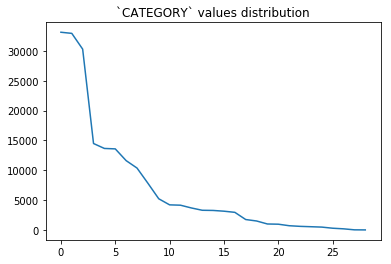


 STAT_DESC: 244
------------------------------------------------
                                             stat_desc  count
220              vehicle and boating laws: misdemeanor  27612
157  narcotics: marijuana misdemeanors (less than 1...  10726
101  grand theft vehicle (gta): automobile/passenge...   9608
224      vehicle burglary: auto/passenger van burglary   8671
153  narcotics: barbiturates etc or any sched iii, ...   6318
20           assault, non-agg: hands, feet, fist, etc.   5732
23          assault, non-aggravated: domestic violence   5669
207  theft, petty: shoplifting (from dept store, mk...   5607
213                                     vandalism misd   5301
155  narcotics: heroin, etc or sched i or ii drugs ...   5239


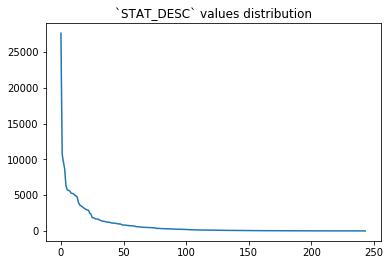


 GANG_RELATED: 2
------------------------------------------------
  gang_related   count
0           no  198614
1          yes    7715

 DELETED: 2
------------------------------------------------
  deleted   count
0       n  206328
1       y       1


In [7]:
for f in ['category', 'stat_desc', 'gang_related', 'deleted']:
    stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
    print('\n {}: {}'.format(f.upper(), len(stats)))
    print('------------------------------------------------')
    print(stats.head(10))
    if len(stats) > 2:
        plt.plot(stats['count'].tolist())
        plt.title('`{}` values distribution'.format(f.upper()))
        plt.show()

In [8]:
categories = set(df.groupby(['category']).size().reset_index(name='count')['category'].tolist())
categories

{'aggravated assault',
 'arson',
 'burglary',
 'criminal homicide',
 'disorderly conduct',
 'drunk / alcohol / drugs',
 'drunk driving vehicle / boat',
 'federal offenses w/o money',
 'federal offenses with money',
 'felonies',
 'forcible rape',
 'forgery',
 'fraud and nsf checks',
 'gambling',
 'grand theft auto',
 'larceny theft',
 'liquor laws',
 'misdemeanors',
 'narcotics',
 'non-aggravated assaults',
 'offenses against family',
 'receiving stolen property',
 'robbery',
 'sex offenses',
 'vagrancy',
 'vandalism',
 'vehicle / boating laws',
 'warrants',
 'weapon laws'}

### 3. Cleaning

In [9]:
columns = sorted(df.columns)

# let's see some different years
for Y in [2005, 2009, 2013, 2016]:
    df = pd.read_csv('data/{}.csv'.format(Y))
    print('\n--- {} --------------------'.format(Y))
    
    cat = set(df.groupby(['category']).size().reset_index(name='count')['category'].tolist())
    if sorted(df.columns) == columns:
        for f in ['category', 'stat', 'stat_desc']:
            stats = df.groupby([f]).size().reset_index(name='count').sort_values('count', ascending = False)
            print('{}: {}'.format(f.upper(), len(stats)))
            
        print('Categories common: {}\nextra: {}\nmiss: {}'\
              .format(len(cat & categories), list(cat - categories), list(categories - cat)))
        
        date = pd.to_datetime(df['incident_date'], errors = 'ignore')
        year = date.apply(lambda d: d if type(d) == str else d.strftime('%Y'))
        miss = len(year[year != str(Y)])
        print('Date miss: {:.2f}% ({})'.format(100 * miss/len(year), miss))
        n = np.random.randint(100,10000)
        print('{} | {} | {}'.format(df.loc[n,'incident_date'], date[n], year[n]))
        miss = len(df[(df['zip'].isnull()) & (df['x_coordinate'].isnull()) & (df['y_coordinate'].isnull())])
        print('Location miss: {:.2f}% ({})'.format(100 * miss/len(df), miss))
    else:
        print('Columns mismatch: {}'.format(sorted(df.columns)))


--- 2005 --------------------
CATEGORY: 29
STAT: 249
STAT_DESC: 249
Categories common: 29
extra: []
miss: []
Date miss: 100.00% (215208)
1/15/2005 2:00:00 am | 1/15/2005 2:00:00 am | 1/15/2005 2:00:00 am
Location miss: 6.96% (14980)

--- 2009 --------------------
CATEGORY: 29
STAT: 247
STAT_DESC: 247
Categories common: 29
extra: []
miss: []
Date miss: 2.89% (6052)
1/16/2009 3:25:00 pm | 2009-01-16 15:25:00 | 2009
Location miss: 6.40% (13396)

--- 2013 --------------------
CATEGORY: 30
STAT: 244
STAT_DESC: 244
Categories common: 26
extra: ['sex offenses misdemeanors', 'misdemeanors miscellaneous', 'sex offenses felonies', 'felonies miscellaneous']
miss: ['felonies', 'sex offenses', 'misdemeanors']
Date miss: 2.26% (3841)
02/14/2013 11:15:00 am | 2013-02-14 11:15:00 | 2013
Location miss: 3.24% (5512)

--- 2016 --------------------
CATEGORY: 39
STAT: 328
STAT_DESC: 328
Categories common: 26
extra: ['felonies miscellaneous', 'persons dead', 'commitments', 'juvenile non-criminal', 'persons

Problems to fix: CATEGORY inconsistency and date parsing (inconsistent date-format was fixed in the later archive version: after 2015).

For location we can relay on zipcode or coordinates and drop address and street fields which are somewhat messy. 
We are going to split the incident date field into year, month, day, weekday and hour features for [prediction crime category by season, time and location](Modeling.ipynb). )

We are going to use generalized categorization 2005 - 2017 ([see Taxonomy notebook](Taxonomy.ipynb)).

In [10]:
# drop non-criminal and misdemeanors
drop = ['misdemeanors','sex offenses misdemeanors','miscellaneous non-criminal','misdemeanors miscellaneous',
        'juvenile non-criminal','commitments','disorderly conduct','mentally ill',
        'accidents miscellaneous','accidents traffic/veh./boat',
        'suicide and attempt','persons dead','persons missing','receiving stolen property']

def collapse(x):
    """short category: single word"""

    if x == 'criminal homicide':
        return 'homicide'
    if x == 'forcible rape':
        return 'rape'
    if x == 'grand theft auto':
        return 'gta'
    if x[:13] == 'drunk driving':
        return 'dui'
    if x == 'larceny theft':
        return 'theft'
    if x == 'offenses against family':
        return 'family'
    if 'assault' in x:
        return 'assault'
    return x.split()[0]


In [11]:
def yes_no(x):
    """binary values for Yes/No type"""

    x = x.lower()
    if x[0] == 'n':
        return 0
    if x[0] == 'y':
        return 1
    return None


In [12]:
import re
import datetime

def extract(d):
    """extract/cleanup date-time related features"""

    Y, M, D, W, H = (None for _ in range(5))
    
    def get_hour(groups):
        H, m, s = (int(x) for x in groups[4:7])
        if groups[8] == 'am' and H == 12:
            H = 0
        if groups[8] == 'pm' and 0 < H < 12:
            H += 12
        return H + m/60 + s/3600
        
    if type(d) == str:
        d = d.lower()
        match = re.match(r'^(\d+)/(\d+)/(20\d+)( (\d+):(\d+):(\d+)( (am|pm))?)?', d)
        if match is None:
            match = re.match(r'^(\d+)-([a-z]+)-(\d+)( (\d+):(\d+):(\d+)( (am|pm))?)?', d)
            if match is None:
                return
            else:
                month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
                D = int(match.group(1))
                M = month.index(match.group(2)) + 1
                Y = 2000 + int(match.group(3))
                W = datetime.date(Y, M, D).timetuple()[6]
                if match.group(4) is None:
                    H = -1
                else:
                    H = get_hour(match.groups())
        else:
            M, D, Y = (int(x) for x in (match.groups())[:3])
            W = datetime.date(Y, M, D).timetuple()[6]
            if match.group(4) is None:
                H = -1
            else:
                H = get_hour(match.groups())
    return (Y, M, D, W, H)


Missing coordinates could be inferred from zipcode and backwards. (For this conversion, and for the maps we need latitude and longitude.)

In [13]:
from pyproj import Proj, transform
projection = Proj(' '.join(['+proj=lcc','+lat_1=34.03333333333333','+lat_2=35.46666666666667',
                            '+lat_0=33.5','+lon_0=-118','+x_0=2000000','+y_0=500000','+ellps=GRS80',
                            '+units=us-ft','+no_defs']), preserve_units = True)

def to_lnglat(r):
    """convert state plane coordinates to longitude-latitude"""

    x, y = r['x_coordinate'], r['y_coordinate']
    if np.isnan(x) or np.isnan(y):
        return None, None
    return projection(x, y, inverse = True)


In [14]:
import os
import MySQLdb as db
con = db.connect(os.environ['MYSQL_HOST'], os.environ['DATAUSER'],
                 os.environ['MYSQL_PASS'], os.environ['DATABASE'],
                 int(os.environ['MYSQL_PORT']))
# lookup table
zipcodes = pd.read_sql("""
    SELECT zip, longitude as lng, latitude as lat, primary_city as city
    FROM usps_zcta5 WHERE state = 'CA'
    """, con = con)


def fix_location(r):
    """get the best possible coordinates + zipcode assessment"""
    
    # all is fine: just change zipcode datatype to str
    if not np.isnan(r['zip']) and not np.isnan(r['lat']):
        return [str(int(r['zip'])), r['lng'], r['lat']]
    
    # try to locate within zipcode polygons
    if not np.isnan(r['lat']):
        query = """
        SELECT t.geoid as zip, {} as lng, {} as lat
        FROM us_zcta5 t JOIN usps_zcta5 z ON t.geoid = z.zip
        WHERE ST_Contains(t.shape, ST_GeomFromText('POINT({} {})', 2))
        """
        res = pd.read_sql(query.format(r['lng'], r['lat'], r['lng'], r['lat']), con = con)
        if len(res) == 1:
            return res.values[0].tolist()

    # use zipcode center as location proxy: geocoding is prefered in this case, but might be quite expensive
    if not np.isnan(r['zip']):
        res = zipcodes[zipcodes['zip'] == str(int(r['zip']))]
        if len(res) == 1:
            return res.values[0].tolist()[:3]

    return [None, None, None]


In [15]:
zipcodes.tail()

,zip,lng,lat,city
2648,96157,-119.97,38.94,South Lake Tahoe
2649,96158,-119.96,38.92,South Lake Tahoe
2650,96160,-120.18,39.32,Truckee
2651,96161,-120.24,39.33,Truckee
2652,96162,-120.31,39.30,Truckee


In [16]:
# features to collect
fields =['id','stat','category','date','year','month','day','weekday','hour','address','city','zip','lng','lat','gang']

for Y in range(2005, 2017):
    df = pd.read_csv('data/{}.csv'.format(Y), low_memory = False)
    print('\n--- {} --------------------'.format(Y))

    # remove `deleted` records
    df['deleted'] = df['deleted'].apply(yes_no)
    df = df[df['deleted'] == 0]

    # remove misc misdemeanors
    df = df[~df['category'].isin(drop)]

    # validate date and expand into Y,N,D,W,H
    df['dt'] = df['incident_date'].apply(extract)
    df = df[~df['dt'].isnull()]

    # convert from plane state to longitude-latitude
    df['ll'] = df.apply(to_lnglat, axis = 1)

    # init features
    features = df.loc[:,['category','stat','address','city','zip']]
    features['id'] = df['incident_id']
    dt = ['year','month','day','weekday','hour']
    for i in range(len(dt)):
        features[dt[i]] = df['dt'].apply(lambda x: x[i] )

    features['lng'] = df['ll'].apply(lambda x: x[0])
    features['lat'] = df['ll'].apply(lambda x: x[1])

    features['gang'] = df['gang_related'].apply(yes_no)
    features['category'] = df['category'].apply(collapse)
    cat = set(features.groupby(['category']).size().reset_index(name='count')['category'].tolist())
    print('Categories: {}'.format(len(cat)))

    print('Date miss: {:.4f}%'\
        .format(100 * (1 - len(features[(features['year'] > 2000) & (~features['weekday'].isnull())])/len(features))))
    print('Location miss: {:.4f}%'\
        .format(100 * (1 - len(features[(features['zip'] > 0) | (features['lat'] > 0)])/len(features))))

    # keep records with valid date
    features['date'] = df['dt'].apply(lambda x: datetime.date(x[0], x[1], x[2]))
    features = features[(features['year'] > 2000) & (~features['weekday'].isnull())]
    print('Time miss: {:.4f}%'.format(100 * len(features[features['hour'] == -1])/len(features)))

    # potential `time-unknown` issue
    print('Hour ZERO: {:.4f}%'.format(100 * len(features[features['hour'] == 0])/len(features)))
    print('Hour NOON: {:.4f}%'.format(100 * len(features[features['hour'] == 12])/len(features)))

    features = features[(features['zip'] > 0) | (features['lat'] > 0)]

    # get the best possible coordinates + zipcode assessment
    features[['zip','lng','lat']] = features[['zip','lng','lat']].apply(fix_location, axis = 1)
    print('Failed location: {:.4f}%'.format(100 * len(features[features['zip'].isnull()])/len(features)))
    features = features[~features['zip'].isnull()]
    features['zip'] = df['zip'].apply(lambda x: str(x)[:5])

    # normalize city attr
    features = features.join(zipcodes[['zip','city']].set_index('zip'), on = 'zip', lsuffix = '_orig', rsuffix = '')
    features.loc[features['city'].isnull(), 'city'] = features.loc[features['city'].isnull(), 'city_orig']\
        .apply(lambda x: x if type(x) == float else ' '.join([l[0].upper() + l[1:] for l in x.split()]))

    # reduce to LA bounding-box
    features = features[(features['lng'] > -119) & (features['lng'] < -116)]
    features = features[(features['lat'] > 32) & (features['lat'] < 35)]

    # save csv and json
    features[fields].to_csv('data/F{}.csv'.format(Y), index = False)
    features[fields].to_json('data/F{}.json'.format(Y), orient = 'records')



--- 2005 --------------------
Categories: 24
Date miss: 0.0764%
Location miss: 6.9730%
Time miss: 4.7489%
Hour ZERO: 0.0000%
Hour NOON: 2.0184%
Failed location: 0.0333%

--- 2006 --------------------
Categories: 24
Date miss: 0.0534%
Location miss: 7.2422%
Time miss: 4.6694%
Hour ZERO: 0.0000%
Hour NOON: 1.9773%
Failed location: 0.0478%

--- 2007 --------------------
Categories: 24
Date miss: 0.0525%
Location miss: 6.8407%
Time miss: 4.8200%
Hour ZERO: 0.0000%
Hour NOON: 1.8658%
Failed location: 0.0693%

--- 2008 --------------------
Categories: 24
Date miss: 0.0343%
Location miss: 6.3251%
Time miss: 4.8416%
Hour ZERO: 0.0000%
Hour NOON: 1.9340%
Failed location: 0.1076%

--- 2009 --------------------
Categories: 24
Date miss: 0.0306%
Location miss: 6.3597%
Time miss: 4.8351%
Hour ZERO: 0.0000%
Hour NOON: 1.9233%
Failed location: 0.1314%

--- 2010 --------------------
Categories: 24
Date miss: 0.0335%
Location miss: 6.1093%
Time miss: 4.7572%
Hour ZERO: 0.0000%
Hour NOON: 1.9102%
Faile

### 4. Geocoding

Since April 2018 the coordinate columns has been dropped; geocoding is the one option to try to get the coordinates.

In [17]:
df = pd.read_csv('data/2017.csv')
df['zip'] = df['zip'].apply(lambda z: str(int(z)) if not np.isnan(z) else z)
df['latitude'] = None
df['longitude'] = None
df.head()

,lurn_sak,incident_date,incident_reported_date,category,stat,stat_desc,address,street,city,zip,incident_id,reporting_district,seq,gang_related,unit_id,unit_name,deleted,latitude,longitude
0,18288959,08/03/2017 11:53:00 pm,08/03/2017,vehicle / boating laws,255,vehicle and boating laws: misdemeanor,"4300 rosemead blvd, rosemead, ca 91770",4300 rosemead blvd,rosemead,91770,917-08914-0531,531,8914,no,ca0190005,temple,n,None,None
1,18079991,03/07/2017 08:23:00 am,03/07/2017,miscellaneous non-criminal,720,"vehicle/boating laws, citations: hazardous cit...","clark ave and maple st, bellflower, ca 90706",clark ave and maple st,bellflower,90706,917-05086-1334,1334,5086,no,ca0190013,lakewood,n,None,None
2,18215223,05/24/2017 09:20:00 am,05/24/2017,miscellaneous non-criminal,501,miscellaneous: vehicle repossessed,"11000 alondra blvd, cerritos, ca",11000 alondra blvd,cerritos,NaN,917-02607-2310,2310,2607,no,ca01900r7,cerritos,n,None,None
3,18077911,03/04/2017 10:18:07 pm,03/04/2017,miscellaneous non-criminal,687,"non-criminal, custody incidents - inmate sick/...","11800 s alameda st, lynwood, ca 90262",11800 s alameda st,lynwood,90262,017-00612-5700,5700,612,no,ca0190053,crdf,n,None,None
4,18382253,10/31/2017 05:00:00 am,10/31/2017,accidents traffic/veh./boat,471,"accidents, traffic-vehicle or boat: accident, ...","10th st w and avenue l, lancaster, ca",10th st w and avenue l,lancaster,NaN,917-21237-1124,1124,21237,no,ca0190024,lancaster,n,None,None


In [18]:
address = df['address'].tolist()
len(address)

303414

In [19]:
address[:10]

['4300 rosemead blvd, rosemead, ca  91770',
 'clark ave and maple st, bellflower, ca  90706',
 '11000 alondra blvd, cerritos, ca',
 '11800 s alameda st, lynwood, ca  90262',
 '10th st w and avenue l, lancaster, ca',
 '29400 the old road, castaic, ca  91384',
 '5900 centinela ave, los angeles, ca',
 '20800 s avalon blvd, carson, ca  90746',
 '700 e bonita ave, san dimas, ca  91773',
 '200 universal city plaza dr, universal city, ca  91608']

Since July 2018 Google geocoding requires an account, and no free limit option is available anymore. 
([PAY-AS-YOU-GO](https://developers.google.com/maps/documentation/geocoding/usage-and-billing) price ~$5.00 per 1000 requests.)

In [20]:
import requests

URL = 'https://maps.googleapis.com/maps/api/geocode/json?key={}'.format(os.environ['GOOGLE_MAPS_API_KEY'])

def geocode(address):
    """google geocode requires an account since July 2018"""
    
    res = requests.get('{}&address={}'.format(URL, address)).json()
    # no results or error
    if len(res['results']) == 0:
        return { 'count': 0, 'status': 'failed' }
    else:    
        data = res['results'][0]
        return {'latitude': data.get('geometry').get('location').get('lat'),
                'longitude': data.get('geometry').get('location').get('lng'),
                'zip': [x['short_name'] for x in data.get('address_components') if 'postal_code' in x.get('types')],
                'count': len(res['results']),
                'status': res.get('status') }

#geocode('4931 Coldwater Canyon Ave, Sherman Oaks, CA')

In [21]:
import time
from IPython.display import clear_output

requests_per_second = 50

columns = df.columns.tolist()
lt = columns.index('latitude')
lg = columns.index('longitude')
z = columns.index('zip')

def run():
    """google geocode api has 50 requests per second limit"""
    i = 0
    while i < len(address):
        clear_output(wait = True)
        print('Processing {} + 50 ...'.format(i))
        for b in range(requests_per_second):
            output = geocode(address[i])
            if output['count'] > 0 and output['status'].lower() == 'ok':
                df.iat[i, lt] = output['latitude']
                df.iat[i, lg] = output['longitude']
                if len(output['zip']) > 0:
                    df.iat[i, z] = output['zip'][0]
            else:
                print(output['status'])
            i += 1
        time.sleep(1)

    df.to_csv('data/2017.csv', index = False)

#run() ### how about paying ~$1.5K price for this exercise ?!

In [22]:
df = pd.read_csv('data/2017.csv', low_memory = False)
print('\n--- 2017 --------------------')
    
# remove `deleted` records
df['deleted'] = df['deleted'].apply(yes_no)
df = df[df['deleted'] == 0]

# remove misc misdemeanors
df = df[~df['category'].isin(drop)]

# validate date and expand into Y,N,D,W,H
df['dt'] = df['incident_date'].apply(extract)
df = df[~df['dt'].isnull()]

# init features
features = df.loc[:,['category','stat','address','city','zip']]
dt = ['year','month','day','weekday','hour']
for i in range(len(dt)):
    features[dt[i]] = df['dt'].apply(lambda x: x[i] )

features['gang'] = df['gang_related'].apply(yes_no)
features['id'] = df['incident_id']
features['category'] = df['category'].apply(collapse)
cat = set(features.groupby(['category']).size().reset_index(name='count')['category'].tolist())
print('Categories: {}'.format(len(cat)))
    
print('Date miss: {:.4f}%'\
    .format(100 * (1 - len(features[(features['year'] > 2000) & (~features['weekday'].isnull())])/len(features))))

# keep records with valid date
features['date'] = df['dt'].apply(lambda x: datetime.date(x[0], x[1], x[2]))
features = features[(features['year'] > 2000) & (~features['weekday'].isnull())]
print('Time miss: {:.4f}%'.format(100 * len(features[features['hour'] == -1])/len(features)))

# potential `time-unknown` issue
print('Hour ZERO: {:.4f}%'.format(100 * len(features[features['hour'] == 0])/len(features)))
print('Hour NOON: {:.4f}%'.format(100 * len(features[features['hour'] == 12])/len(features)))
    
print('No zipcode: {:.4f}%'.format(100 * len(features[features['zip'].isnull()])/len(features)))

#feature['lng'] = None
#feature['lat'] = None
#features[fields].to_csv('data/F{}.csv'.format(Y), index = False)


--- 2017 --------------------
Categories: 24
Date miss: 0.0018%
Time miss: 0.0000%
Hour ZERO: 2.3814%
Hour NOON: 2.2907%
No zipcode: 43.9471%


Unfortunately, the result with geocoding is not satisfying either: ~20% of records failed to recover location. 
(Census manual [geocoding for batches under 10000 records](https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form) is still available and free, but impractical for the job of 10x100000 order.)

Plain python version of this job is **archive-audit** script.